# Predicting Course Failure with Decision Trees

For this project, I will take a data set of three years worth of term grades and build a model to predict whether a student is likely to fail a course for the year.

In [1]:
% matplotlib inline
import pandas as pd
import seaborn as sns

sns.set_style('white')

In [2]:
## import data
passfail = pd.read_csv('failureprediction.csv', index_col='studentid')

print len(passfail), 'observations'
passfail.head()

40190 observations


,academic_year,att_pct,n_demerits,course_number,term,grade_pct,failed_course
studentid,,,,,,,
8,2011,96,4,DRA10,Q1,88,0
8,2011,96,4,ENG40,Q1,72,0
8,2011,96,4,HIST40,Q1,74,0
8,2011,96,4,MATH40,Q1,76,1
8,2011,96,4,RHET40,Q1,89,0


In [3]:
passfail.describe()

,academic_year,att_pct,n_demerits,grade_pct,failed_course
count,40190.000000,40190.000000,40190.000000,40190.000000,40190.000000
mean,2012.171635,90.263896,14.214208,77.035531,0.195944
std,0.797275,11.017330,14.197677,12.945124,0.396931
min,2011.000000,7.000000,1.000000,50.000000,0.000000
25%,2012.000000,86.000000,4.000000,70.000000,0.000000
50%,2012.000000,94.000000,10.000000,78.000000,0.000000
75%,2013.000000,98.000000,19.000000,87.000000,0.000000
max,2013.000000,100.000000,135.000000,111.000000,1.000000


## Data Preparation

In [4]:
## course number contains some potentially useful information, but it is a hash of subject and course level
## using regex, I'll split it into multiple columns for better analysis
import re    

## create clean df for modifications, dropping any NaN rows
passfail_c = passfail.dropna()

## couldn't figure out how to do this well with one function, so here's two:
def parse_course(coursenum):    
    n = re.split('(\d+)', coursenum)
    course = n[0]
    #level = n[1]
    return course

def parse_level(coursenum):
    import re    
    n = re.split('(\d+)', coursenum)
    level = n[1]
    return level

## create separate columns for each part of the course number
passfail_c['level'] = passfail_c.course_number.apply(parse_level).astype('int')
passfail_c['course'] = passfail_c.course_number.apply(parse_course)

## map dummy values to subjects for use in algorithm
passfail_c['course_dummy'] = passfail_c.course.map({'DRA':0,
                                                    'ENG':1,
                                                    'HIST':2,
                                                    'MATH':3,
                                                    'RHET':4,
                                                    'SCI':5,
                                                    'SPAN':6,
                                                    'GYM':7,
                                                    'ART':8,
                                                    'FREN':9,
                                                    'STUDY':10,
                                                    'WRI':11,
                                                    'THE':12,
                                                    'ARAB':13,
                                                    'BUS':14})

## map integers to term numbers for use in algorithm
passfail_c['term'] = passfail_c.term.map({'Q1':1, 'Q2':2, 'Q3':3, 'Q4':4})

passfail_c.head()

,academic_year,att_pct,n_demerits,course_number,term,grade_pct,failed_course,level,course,course_dummy
studentid,,,,,,,,,,
8,2011,96,4,DRA10,1,88,0,10,DRA,0
8,2011,96,4,ENG40,1,72,0,40,ENG,1
8,2011,96,4,HIST40,1,74,0,40,HIST,2
8,2011,96,4,MATH40,1,76,1,40,MATH,3
8,2011,96,4,RHET40,1,89,0,40,RHET,4


We have 3 full years worth of data, so let's split it up into two sets: one for building the model and one for evaluating it

In [5]:
passfail_sample = passfail_c[passfail_c.academic_year < 2013]
passfail_oos = passfail_c[passfail_c.academic_year == 2013]

## Target

The target, *failed_course*, is a binary variable that indicates whether a student failed a course for the year, represented by a 1 if they failed and a 0 if they passed.

Being able to preict failure can be a very powerful tool for a school with multiple applications:
- Early on in the year, it is important so that the proper interventions can be put in place to minimize the likelyhood of the prediction coming to fruition.
- Later in the year, it's also a important to plan staffing and course offerings for the next year. If a large enough number of students are predicted to fail a course, it will be necessary to have an additional period and teacher to accommodate the students who retake the course the following year.

### Histogram of Passing (0) vs Failing (1) students

Overall, most students pass their classes, but there is a solid ~15% of courses that students fail

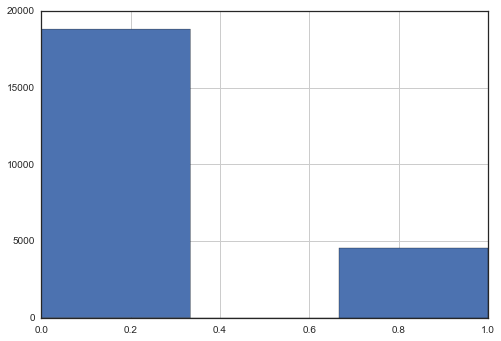

In [6]:
passfail_sample.failed_course.hist(bins=3)

### Histogram of Passing vs Failing students, cut by school year

The failure rate looks pretty consistent across years, which is great (for modeling purposes).  Our algorithm should be applicable across multiple years.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000018920E80>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000001A5A89E8>], dtype=object)

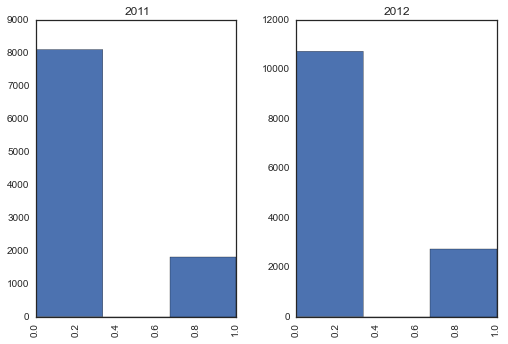

In [7]:
passfail_sample.failed_course.hist(bins=3, by=passfail_sample.academic_year)

## Features

| Feature Name | Description |
|--------------|-------------|
| academic_year | school year during which the observation occurred |
| term | the term for the associated data, there a four quarters in a school year |
| course | the subject of the associated course, derived from *course_number* | 
| level | the level of the associated course, derived from *course_number* |
| grade_pct | a student's grade for the term |
| att_pct | a student's average daily attendance for the term |
| n_demerits | a student's number of behavior infractions for the term |

### Attendance

It doesn't take a machine learning algortihm to arrive at the idea that being absent for school is probably going to impact your grade.  However, if it's significnat enough to use in a predicitive model, all the better.

The mean for attendance is usually high (for this sample, it's ~92%), since only a small number of students are chronically absent.

count    23376.000000
mean        91.878893
std         10.159625
min          7.000000
25%         89.000000
50%         95.000000
75%         98.000000
max        100.000000
Name: att_pct, dtype: float64


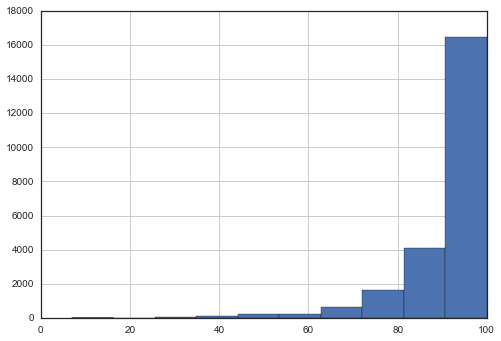

In [8]:
print passfail_sample.att_pct.describe()
passfail_sample.att_pct.hist(bins=10)

### Demerits

Behavioral infractions may or may not be an indicator for class performance, but it is worth exploring whether chronic behavior problems have any impact on grades.

count    23376.000000
mean        12.169918
std         12.426146
min          1.000000
25%          4.000000
50%          8.000000
75%         16.000000
max        108.000000
Name: n_demerits, dtype: float64


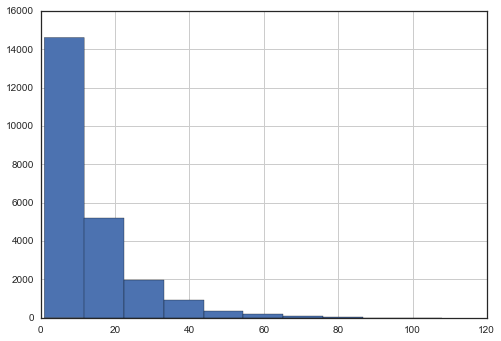

In [9]:
print passfail_sample.n_demerits.describe()
passfail_sample.n_demerits.hist()

### Term Grades

Term grades are obviously going to be predictive of whether a student passes or fails, but what's great about this experiment is that the machine learning algorthim is going in blind.  It has no idea what "passing" is or if there is any weighting by terms (in reality, there is).

The histogram resembles the classic bell curve, with most students in the 80% range.

count    23376.000000
mean        77.120508
std         12.873930
min         50.000000
25%         70.000000
50%         78.000000
75%         87.000000
max        110.000000
Name: grade_pct, dtype: float64


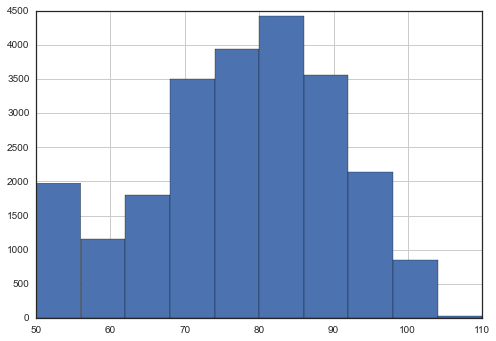

In [10]:
print passfail_sample.grade_pct.describe()
passfail_sample.grade_pct.hist(bins=10)

### Other Features

- Course: the subject that the class is in, it'd be interesting if the algorithm could find some significance depending on the subject
- Level: intuition says that harder courses will be harder to pass, let's see if our robot can figure that out too.
- Term: if it can find some correlation between term and pass/fail, it should be able to predict outcomes earlier in the year.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001B089588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000020EF8C18>]], dtype=object)

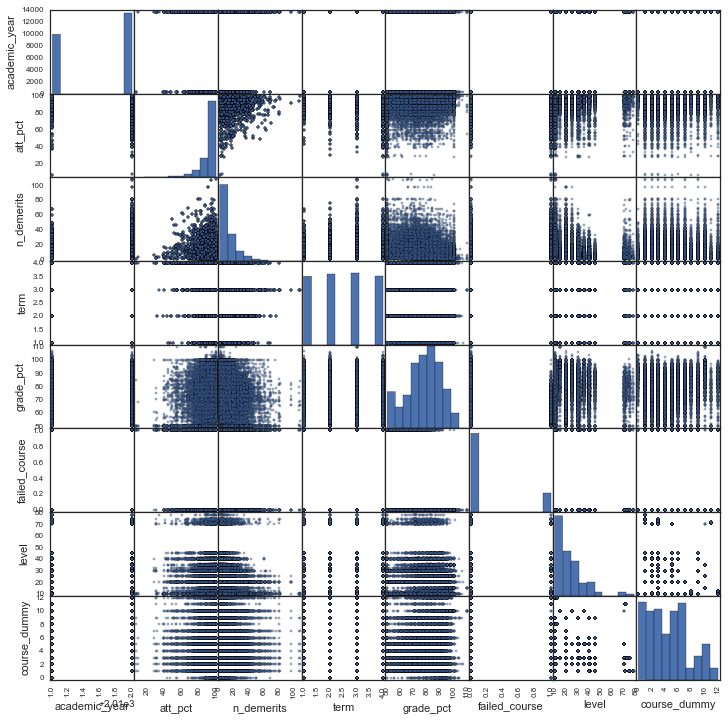

In [11]:
pd.scatter_matrix(passfail_sample, figsize=(12,12))

### Feature Selection

Let's run through our features, comparing them to the target variable, and keep only the ones that have a significant correlation (p < 0.05).

In [12]:
from sklearn import feature_selection as f_select

features = list(passfail_sample.columns)
features.remove('failed_course') ## target variable
features.remove('academic_year') ## let's see how this performs independent of year
features.remove('course_number') ## split into multiple columns
features.remove('course') ## converted to dummy variable

print 'original feature list:', features, '\n'

## assign our target variable
y = passfail_sample.failed_course

## loop through feature set and store significant features in a variable
significant_features = []
pvals = []
for feature in features:
    pval = f_select.f_classif(passfail_sample[feature], y)
    print feature, pval[1][0]
    if pval[1][0] < 0.05:
        significant_features.append(feature)        
        pvals.append(pval[1][0])
        
print '\nsignificant features:', significant_features        

## create a dataframe with only significant columns
X = passfail_sample[significant_features]

original feature list: ['att_pct', 'n_demerits', 'term', 'grade_pct', 'level', 'course_dummy'] 

att_pct 2.79249317987e-272
n_demerits 7.82933441929e-287
term 0.183152344534
grade_pct 0.0
level 8.27977602592e-47
course_dummy 4.55490053384e-56

significant features: ['att_pct', 'n_demerits', 'grade_pct', 'level', 'course_dummy']


It seems that *term* is the only feature that isn't significantly correlated with the target.  I think this puts a damper on some of the predicitive value it could have offered, but it's great to see that we were able to find correlation within most of the other features.

## Test/Train Split

We are trying to solve a classification problem (will a student pass or fail a course given some inputs), so we want to use a classifier.  In class, we covered two major types: Naive Bayes and Decision Trees.

Naive Bayes will try to classify an observation based on what it already knows about the data set's features.

A Decision Tree will determine the importance each feature to the dataset and then create a series of rules that splits the data into subsets based on their characterisitics.

We'll split up the sample dataset into a testing set and a training set to see which performs the best at predicting our target.

In [13]:
from sklearn import cross_validation, naive_bayes, tree

def train_and_measure(classifier, x, y):    
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2, random_state=1234)
    clf = classifier.fit(xtrain, ytrain)    
    training_accuracy = clf.score(xtrain, ytrain)
    test_accuracy = clf.score(xtest, ytest)
    print classifier
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print

train_and_measure(naive_bayes.MultinomialNB(), X, y)

x_ones = (X > 1) # bernoulli will only work with 1s and 0s, or binary data.
train_and_measure(naive_bayes.BernoulliNB(), x_ones, y)

train_and_measure(tree.DecisionTreeClassifier(), X, y) ## 100% is suspect but totally possible when a tree has no stopping criteria
train_and_measure(tree.DecisionTreeClassifier(max_depth=10), X, y) ## still does better when stopping criteria is limited

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Accuracy on training data: 0.76
Accuracy on test data:     0.75

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Accuracy on training data: 0.81
Accuracy on test data:     0.80

DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=None, splitter='best')
Accuracy on training data: 1.00
Accuracy on test data:     0.83

DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=None, splitter='best')
Accuracy on training data: 0.91
Accuracy on test data:     0.87



## Model Building

The Decision Tree performs better than both types of Naive Bayes classifiers.

One thing I noticed when I first evaluated it was that without stopping criteria, it was perfect, which is suspect because you need to assume some error in any model.  However, once I added a depth limit, it lowered the accuracy to 91%, which is still good and still better than both Naive Bayes classifiers.

Let's try to optimize the Decision Tree for depth to seem if we can get some additional accuracy...

Best score: 0.916526946161
5


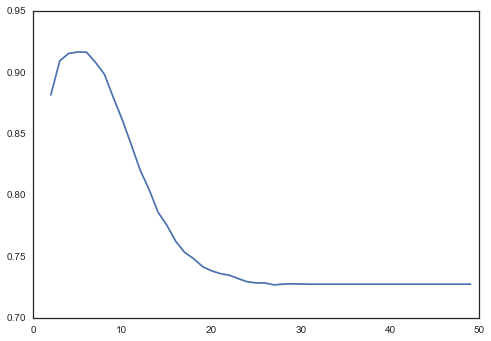

In [14]:
from sklearn.cross_validation import cross_val_score
from matplotlib import pyplot as plt

## loop over decision tree depth to find where accuracy peaks
all_scores = []
best_score = -1
max_param = 50
for param in range(2, max_param):    
    scores = cross_val_score(tree.DecisionTreeClassifier(max_depth=param, random_state=1234),
                                 X,
                                 y,
                                 scoring='roc_auc',
                                 cv=5)
    if scores.mean() > best_score:
        best_param = param
        best_score = scores.mean()
    all_scores.append(scores.mean())

print 'Best score:', best_score
print best_param

## visualize it
plt.figure()
plt.plot(range(2, max_param), all_scores)

In [15]:
## looks like a depth of 5 is the best, let's run with that!
treeclf = tree.DecisionTreeClassifier(max_depth=5).fit(X, y)

# compute the feature importances
pd.DataFrame({'feature':significant_features, 'importance':treeclf.feature_importances_})

,feature,importance
0,att_pct,0.006144
1,n_demerits,0.004922
2,grade_pct,0.966963
3,level,0.018789
4,course_dummy,0.003182


## Model Scoring

Now that we've built the model, let's see how well it does.

We can use a number of metrics to evaulate our model.  Two major ones we'll use are **Accuracy** and the **AUC score**

- Accuracy is the overall percentage of correct predictions that the model made for the data set
    - it can be further explained with a confusion matrix, which summarizes the number of true and false (both positive and negative) predictions of the model
- Area Under the Curve (AUC) computes the area under a Receiver Operating Characteristic (ROC) curve.
    - This curve is the plot of the percentage of predicted true-positives against the percentage of false positives
    - The higher score, the better.  For a binomial target, you want to see the AUC higher than 0.5, which is effectively random

[[17943   872]
 [ 1800  2761]]

false positive rate: 0.0463460005315
true positive rate: 0.605349704012
accuracy: 0.885694729637

AUC score: 0.77950185174


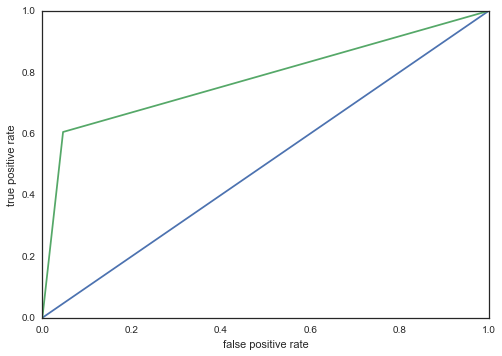

In [16]:
from sklearn import metrics

conf = metrics.confusion_matrix(y, treeclf.predict(X))
print conf
print

print 'false positive rate:', metrics.roc_curve(y, treeclf.predict(X))[0][1]
print 'true positive rate:', metrics.roc_curve(y, treeclf.predict(X))[1][1]
print 'accuracy:', metrics.accuracy_score(y, treeclf.predict(X))
print

roc = metrics.roc_curve(y, treeclf.predict(X))

plt.figure()
plt.plot([0, 0.5, 1], [0, 0.5, 1])
plt.plot(roc[0], roc[1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

auc = metrics.roc_auc_score(y, treeclf.predict(X))
print 'AUC score:', auc

Does pretty great!  Granted, the percentage is an obvious predictor of course failure, it's kind of amazing that this algorithm can ascertain that from the data without any additional context or explicit rules.

# Predict

Now that we've seen some success with the sample that built the model, let's try it with last year's data and see if it can perform similarly well...

In [17]:
X_oos = passfail_oos[significant_features]
y_oos = passfail_oos.failed_course

false positive rate: 0.0507407407407
true positive rate: 0.635787567894
accuracy: 0.887474723445
AUC score: 0.792523413577


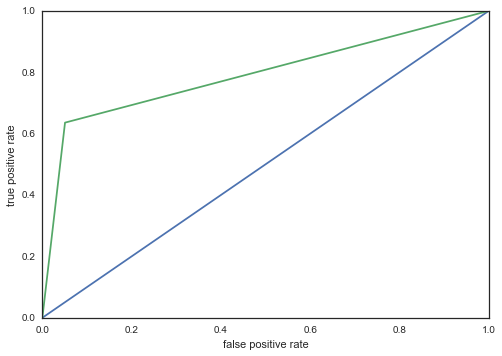

In [18]:
print 'false positive rate:', metrics.roc_curve(y_oos, treeclf.predict(X_oos))[0][1]
print 'true positive rate:', metrics.roc_curve(y_oos, treeclf.predict(X_oos))[1][1]
print 'accuracy:', metrics.accuracy_score(y_oos, treeclf.predict(X_oos))

roc = metrics.roc_curve(y_oos, treeclf.predict(X_oos))

plt.figure()
plt.plot([0, 0.5, 1], [0, 0.5, 1])
plt.plot(roc[0], roc[1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

auc = metrics.roc_auc_score(y_oos, treeclf.predict(X_oos))
print 'AUC score:', auc

It does almost exactly as well, slightly better!

Let's take this one step further and use this year's data, for which we only have 2 quarters worth of data and see how it predicts failure.

In [19]:
## import the current year's data and perform the same cleanup operations
passfail2014 = pd.read_csv('failureprediction2014.csv', index_col='studentid')

import re    

def parse_course(coursenum):    
    n = re.split('(\d+)', coursenum)
    course = n[0]    
    return course

def parse_level(coursenum):
    import re    
    n = re.split('(\d+)', coursenum)
    level = n[1]
    return level

passfail2014['term'] = passfail2014.term.map({'Q1':1, 'Q2':2, 'Q3':3, 'Q4':4})

passfail2014['course'] = passfail2014.course_number.apply(parse_course)
passfail2014['course_dummy'] = passfail2014.course.map({'DRA':0,
                                                  'ENG':1,
                                                  'HIST':2,
                                                  'MATH':3,
                                                  'RHET':4,
                                                  'SCI':5,
                                                  'SPAN':6,
                                                  'GYM':7,
                                                  'ART':8,
                                                  'FREN':9,
                                                  'STUDY':10,
                                                  'WRI':11,
                                                  'THE':12,
                                                  'ARAB':13,
                                                  'BUS':14})

passfail2014['level'] = passfail2014.course_number.apply(parse_level).astype('int')

passfail2014.describe()

,academic_year,att_pct,n_demerits,term,grade_pct,failed_course,course_dummy,level
count,9325,9325.000000,9325.000000,9325.000000,9325.000000,0,9325.000000,9325.000000
mean,2014,91.593351,21.907024,1.501019,78.437705,NaN,4.211367,22.252976
std,0,9.093230,18.583084,0.500026,13.517090,NaN,3.005686,15.933757
min,2014,26.000000,1.000000,1.000000,50.000000,NaN,1.000000,1.000000
25%,2014,88.000000,8.000000,1.000000,71.000000,NaN,2.000000,10.000000
50%,2014,94.000000,17.000000,2.000000,80.000000,NaN,3.000000,20.000000
75%,2014,98.000000,31.000000,2.000000,88.000000,NaN,6.000000,30.000000
max,2014,100.000000,118.000000,2.000000,219.000000,NaN,13.000000,78.000000


           att_pct course  failed_course  grade_pct  n_demerits  term
studentid                                                            
3352            90   MATH              1         62          43     2
3352           100   MATH              0         79          28     1
3352           100   HIST              0         79          28     1
3352            90   HIST              0         73          43     2
3352           100    GYM              0         79          28     1
3352            90    GYM              0         85          43     2
3352           100    WRI              0         95          28     1
3352            90    WRI              0         81          43     2
3352           100    ENG              0         89          28     1
3352            90    ENG              0         72          43     2
3352            90    SCI              0         66          43     2
3352           100    SCI              1         60          28     1
3352            90  

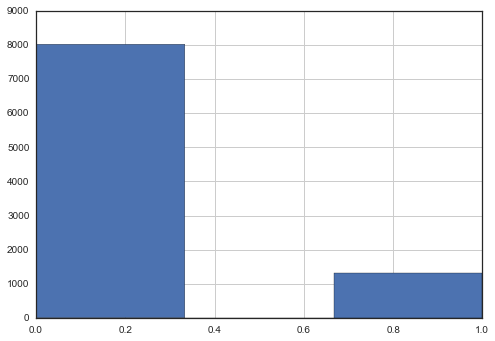

In [20]:
## predict
X_curr = passfail2014[significant_features]
y_pred = treeclf.predict(X_curr)

predictions = pd.DataFrame({'term':passfail2014.term,
                            'att_pct':passfail2014.att_pct, 
                            'n_demerits':passfail2014.n_demerits, 
                            'course':passfail2014.course, 
                            'grade_pct':passfail2014.grade_pct,                             
                            'failed_course':y_pred})

## print out one student
print predictions[predictions.index == 3352]

predictions.failed_course.hist(bins=3)

Looks familiar!  This particular student is interesting because while some of his term averages are below passing (70%), his higher attendance or number of demerits may be pushing him in the right direction according to the algorithm.

## Summary

- Given no specific criteria about passing rate, a Decision Tree can build a reliable predicitive model for whether a student will pass or fail a class
- Attendance and behavior data also have a place in the model for predicting failure
- Unfortunately, term wasn't significant enough to come into play, which I feel could have added some predictive power

## Next Steps
- Visualize the tree
- Look into normalizing some of the data, specifically demerits and attendance, which had very skewed distributions.
- Find other features that can add to the model.
- The algorithm works with an incomplete year, so I should save these results and evaluate its effectiveness at the end of the school year.